In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math

In [31]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# 1. 定義基本參數與限制 (Constraints)
GRID_SIZE = 20            # 地圖大小 20x20
NUM_CONSUMERS = 1000      # 消費者數量
DAYS = 365                # 模擬天數

# 增加限制：品質越高，成本越高
# 假設每提升 1 分品質，成本增加 3 元
COST_FACTOR = 0.8         # 用來控制曲線陡峭程度
BASE_COST = 25            # 基礎成本

def calculate_cost(quality):
    """
    非線性成本函數：品質越高，成本呈指數級/平方級上升
    """
    return BASE_COST + (COST_FACTOR * (quality ** 2))

In [ ]:
class CoffeeShop:
    def __init__(self, name, price, quality, x, y):
        self.name = name
        self.price = price
        self.quality = quality
        self.location = np.array([x, y])
        
        # 計算單位成本
        self.unit_cost = calculate_cost(quality)
        
        # 記錄營收與利潤
        self.daily_revenue = []
        self.daily_profit = []
        self.total_profit = 0

    def reset_history(self):
        self.daily_revenue = []
        self.daily_profit = []
        self.total_profit = 0

    def add_sales(self, count):
        """計算當天的營收與利潤"""
        revenue = count * self.price
        cost = count * self.unit_cost
        profit = revenue - cost
        
        self.daily_revenue.append(revenue)
        self.daily_profit.append(profit)
        self.total_profit += profit

class Consumer:
    def __init__(self, id):
        self.id = id
        # 隨機分佈在地圖上
        self.location = np.array([random.uniform(0, GRID_SIZE), random.uniform(0, GRID_SIZE)])

        # 我們將消費者分為兩類：
        # 1. 小資族 (60%)：預算低，對價格敏感，對品質要求普通
        # 2. 菁英族 (40%)：預算高，不在乎價格，只追求品質
        if random.random() < 0.6: 
            # 小資族 (Mass Market)
            self.type = "Budget"
            self.budget = random.uniform(45, 90)
            self.w_quality = random.uniform(0.5, 1.5) # 對品質要求一般
            self.w_price = random.uniform(3.0, 5.0)   # 非常在意價格
        else:
            # 菁英族 (High-End Market)
            self.type = "Elite"
            self.budget = random.uniform(70, 200)     # 預算很高
            self.w_quality = random.uniform(4.0, 7.0) # 極度在意品質
            self.w_price = random.uniform(0.1, 0.5)   # 不太在意價格

        self.w_dist = random.uniform(0.2, 1.0)

    def decide(self, shops, day):
        """
        核心決策函數：計算每一家店的效用 (Utility) 並選擇最高的
        Utility = (a * Q) - (b * P) - (c * D) + Noise
        """
        best_shop_idx = -1
        max_utility = -float('inf')

        # 判斷是否週末
        is_weekend = (day % 7) >= 5

        for idx, shop in enumerate(shops):
            # 預算檢查
            if shop.price > self.budget:
                continue # 買不起，跳過這家店

            # 計算距離 (歐幾里得距離)
            distance = np.linalg.norm(self.location - shop.location)
            noise = random.gauss(0, 3) # 增加一點隨機性
            
            # 計算效用 (加入一點隨機雜訊模擬人類的不確定性)
            # 使用 sqrt 讓品質效用非線性 (邊際效用遞減)
            # 這樣從 1->2 的提升感很大，但 9->10 的提升感很小
            # 把 Quality * 10 放大一點數值以免 log/sqrt 太小
            perceived_quality = math.sqrt(shop.quality * 10)

            # 如果是週末，大家比較不在意距離 (願意去遠的好店)
            current_w_dist = self.w_dist * 0.7 if is_weekend else self.w_dist

            utility = (self.w_quality * perceived_quality) - \
                      (self.w_price * shop.price) - \
                      (current_w_dist * distance) + noise
            
            if utility > max_utility:
                max_utility = utility
                best_shop_idx = idx
        
        return best_shop_idx

class MarketSimulator:
    def __init__(self):
        self.consumers = [Consumer(i) for i in range(NUM_CONSUMERS)]
        # 設定 3 家固定的競爭對手 (價格, 品質, x, y)
        self.competitors = [
            CoffeeShop("Competitor A (High-End)", price=130, quality=9, x=5, y=15),
            CoffeeShop("Competitor B (Cheap)",    price=45, quality=2, x=15, y=5),
            CoffeeShop("Competitor C (Balanced)", price=80, quality=6, x=15, y=15)
        ]

    def run_simulation(self, my_strategy, days=365):
        """
        運行一次完整的模擬
        my_strategy: [price, quality, x, y]
        """
        # 1. 建立你的商店
        my_shop = CoffeeShop("My Shop", *my_strategy)
        all_shops = self.competitors + [my_shop]
        
        # 重置所有商店紀錄
        for shop in all_shops:
            shop.reset_history()

        # 2. 模擬每一天
        for day in range(days):
            daily_counts = [0] * len(all_shops)
            
            # 每個消費者做決定
            for consumer in self.consumers:
                choice = consumer.decide(all_shops, day)
                if choice != -1: # 如果消費者有做出選擇 (沒被預算全擋掉)
                    daily_counts[choice] += 1
            
            # 結算當天業績
            for idx, shop in enumerate(all_shops):
                shop.add_sales(daily_counts[idx])

        return my_shop

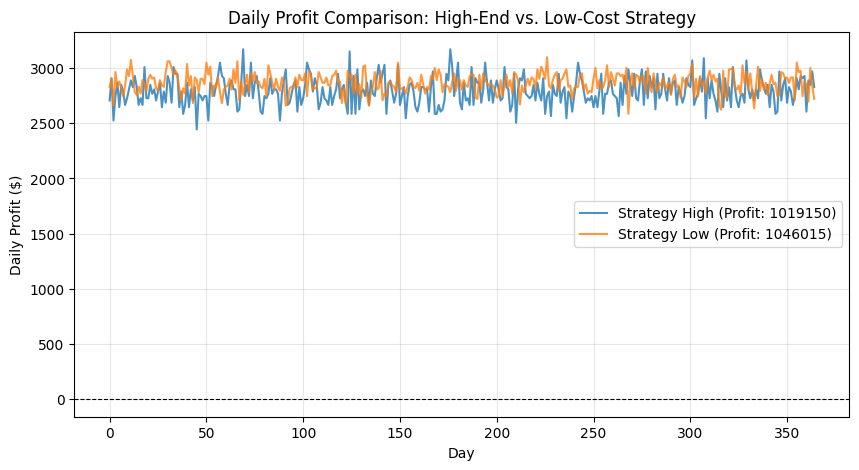

正在生成熱力圖數據...


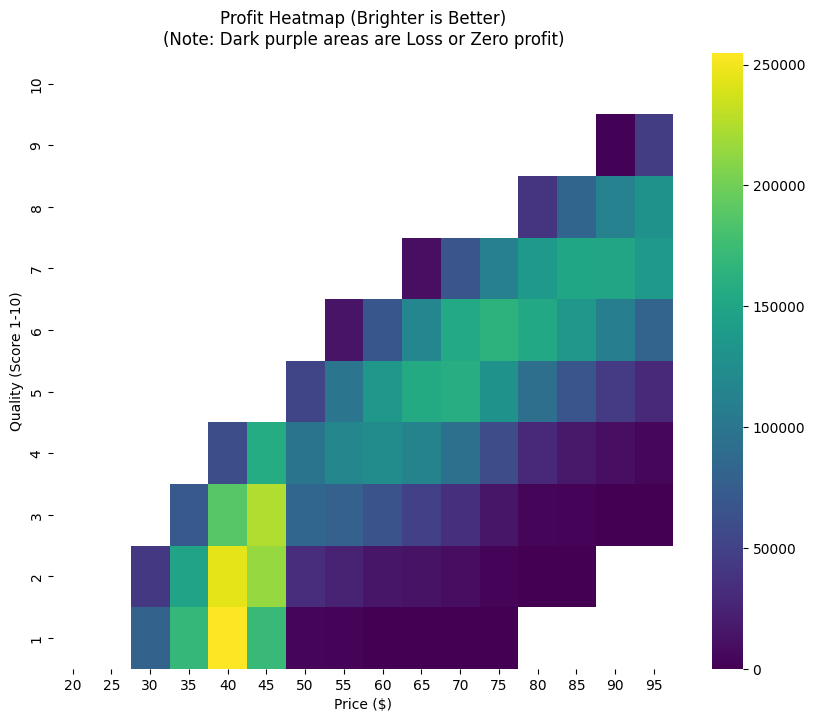

In [43]:
simulator = MarketSimulator()

# --- 實驗 A: 策略對決 (營收/利潤曲線) ---
# 策略 1: 走高品質高價路線
strategy_high = [110, 9, 5, 5] # Price=85, Quality=9, Location=(5,5)
# 策略 2: 走低價親民路線
strategy_low  = [50, 4, 5, 5] # Price=45, Quality=4, Location=(5,5) (地點相同以控制變因)

shop_result_high = simulator.run_simulation(strategy_high)
shop_result_low = simulator.run_simulation(strategy_low)

plt.figure(figsize=(10, 5))
plt.plot(shop_result_high.daily_profit, label=f'Strategy High (Profit: {int(shop_result_high.total_profit)})', alpha=0.8)
plt.plot(shop_result_low.daily_profit, label=f'Strategy Low (Profit: {int(shop_result_low.total_profit)})', alpha=0.8)
plt.title("Daily Profit Comparison: High-End vs. Low-Cost Strategy")
plt.xlabel("Day")
plt.ylabel("Daily Profit ($)")
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 實驗 B: 尋找最佳解 (熱力圖 Heatmap) ---
print("正在生成熱力圖數據...")

# 設定參數範圍
prices = np.arange(20, 100, 5)   # 價格從 20 到 100
qualities = np.arange(1, 11, 1)  # 品質從 1 到 10
profit_matrix = np.zeros((len(qualities), len(prices)))

# 固定地點在中心 (10, 10) 進行測試
fixed_x, fixed_y = 10, 10

for i, q in enumerate(qualities):
    for j, p in enumerate(prices):
        cost = calculate_cost(q)
        result = simulator.run_simulation([p, q, fixed_x, fixed_y], days=30)
        profit_matrix[i, j] = result.total_profit

# 繪製熱力圖
plt.figure(figsize=(10, 8))
# 找出最大獲利值，用來設定顏色上限，避免被極端值影響
max_profit = np.max(profit_matrix)

# 設定 vmin=0，代表我們只關心「有賺錢」的區域顏色變化
# 使用 mask 將虧損 (<=0) 的區域遮蔽成灰色，讓獲利區更明顯
mask = profit_matrix <= 0
# 虧損的區域 (小於0) 會變成此色系的最底端顏色 (或是我們可以用 mask 遮掉)
sns.heatmap(profit_matrix, annot=False, cmap="viridis", mask=mask,
            xticklabels=prices, yticklabels=qualities,
            vmin=0, vmax=max_profit) # 關鍵：鎖定顯示範圍
plt.title(f"Profit Heatmap (Brighter is Better)\n(Note: Dark purple areas are Loss or Zero profit)")
plt.xlabel("Price ($)")
plt.ylabel("Quality (Score 1-10)")
plt.gca().invert_yaxis() # 讓品質 10 在上面
plt.show()

=== 開始全域最佳化搜尋 (Non-Linear Cost) ===
成本結構範例:
  Quality 1: Cost $25
  Quality 3: Cost $32
  Quality 5: Cost $45
  Quality 8: Cost $76
  Quality 10: Cost $105

>>> 階段一：快速篩選...

>>> 階段二：深度決賽 (365天) - 前 5 名策略
策略 [P:42, Q:1, Loc:(13,6)] -> 年利潤: $3431532
策略 [P:42, Q:1, Loc:(7,7)] -> 年利潤: $3426834
策略 [P:43, Q:2, Loc:(10,11)] -> 年利潤: $3411059
策略 [P:42, Q:1, Loc:(17,5)] -> 年利潤: $3392522
策略 [P:43, Q:1, Loc:(14,2)] -> 年利潤: $3325499

🏆 最終冠軍策略 🏆
地點: (13, 6)
定價: $42 (成本: $25)
品質: 1 分
預估年利潤: $3431532


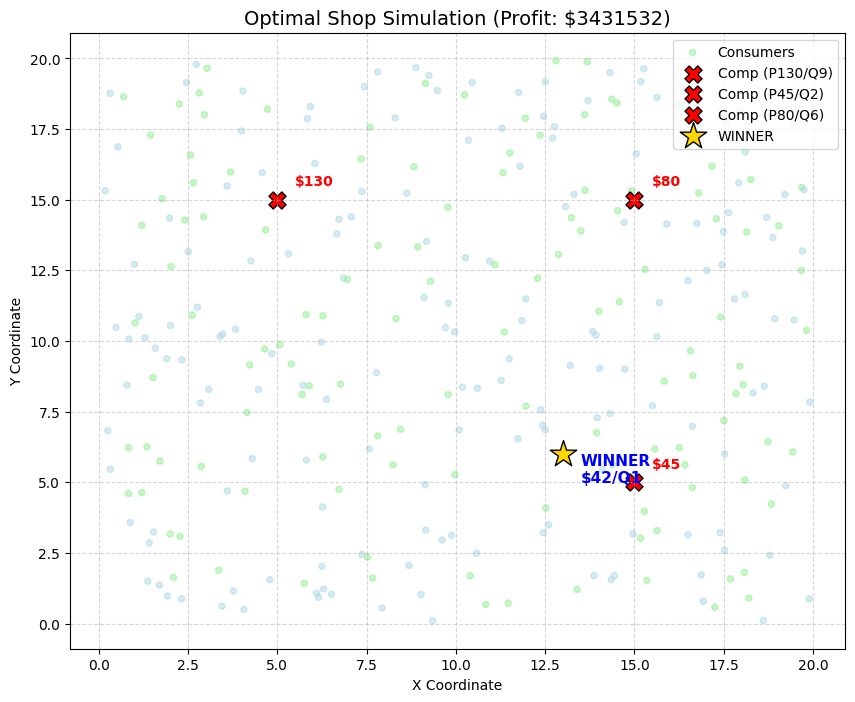

In [44]:
# 3. 全域最佳化搜尋
simulator = MarketSimulator()

print("=== 開始全域最佳化搜尋 (Non-Linear Cost) ===")
# 顯示一下成本結構給你看
print(f"成本結構範例:")
for q in [1, 3, 5, 8, 10]:
    print(f"  Quality {q}: Cost ${int(calculate_cost(q))}")

# 1. 蒙地卡羅採樣
num_candidates = 600
candidates = []

for _ in range(num_candidates):
    cx = random.randint(0, GRID_SIZE)
    cy = random.randint(0, GRID_SIZE)
    cq = random.randint(1, 10)
    
    cost = calculate_cost(cq)
    # 價格策略：成本 + 合理利潤 (10~60)
    cp = random.randint(int(cost) + 10, int(cost) + 60)
    
    candidates.append([cp, cq, cx, cy])

# 2. 快速篩選 (30天)
print("\n>>> 階段一：快速篩選...")
best_candidates = []
for strat in candidates:
    result = simulator.run_simulation(strat, days=30)
    best_candidates.append((result.total_profit, strat))

best_candidates.sort(key=lambda x: x[0], reverse=True)
top_5 = best_candidates[:5]

print("\n>>> 階段二：深度決賽 (365天) - 前 5 名策略")
final_results = []
for profit_30, strat in top_5:
    result = simulator.run_simulation(strat, days=365)
    final_results.append((result.total_profit, strat))
    print(f"策略 [P:{strat[0]}, Q:{strat[1]}, Loc:({strat[2]},{strat[3]})] -> 年利潤: ${int(result.total_profit)}")

final_results.sort(key=lambda x: x[0], reverse=True)
winner_profit, winner_strat = final_results[0]

print(f"\n🏆 最終冠軍策略 🏆")
print(f"地點: ({winner_strat[2]}, {winner_strat[3]})")
print(f"定價: ${winner_strat[0]} (成本: ${int(calculate_cost(winner_strat[1]))})")
print(f"品質: {winner_strat[1]} 分")
print(f"預估年利潤: ${int(winner_profit)}")

# ==========================================
# 4. 視覺化
# ==========================================
plt.figure(figsize=(10, 8))

# 畫出部分消費者
sample_consumers = random.sample(simulator.consumers, 300)
x_con = [c.location[0] for c in sample_consumers]
y_con = [c.location[1] for c in sample_consumers]
colors = ['lightblue' if c.type == "Budget" else 'lightgreen' for c in sample_consumers]
plt.scatter(x_con, y_con, c=colors, alpha=0.5, s=20, label='Consumers')

# 畫出競爭者
for comp in simulator.competitors:
    plt.scatter(comp.location[0], comp.location[1], c='red', marker='X', s=150, edgecolors='black', 
                label=f'Comp (P{comp.price}/Q{comp.quality})')
    plt.text(comp.location[0]+0.5, comp.location[1]+0.5, f"${comp.price}", fontsize=10, fontweight='bold', color='red')

# 畫出冠軍
plt.scatter(winner_strat[2], winner_strat[3], c='gold', marker='*', s=400, edgecolors='black', label='WINNER')
plt.text(winner_strat[2]+0.5, winner_strat[3]-1, f"WINNER\n${winner_strat[0]}/Q{winner_strat[1]}", fontsize=11, fontweight='bold', color='blue')

plt.title(f"Optimal Shop Simulation (Profit: ${int(winner_profit)})", fontsize=14)
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()